In [2]:
from sotip import *
import numpy as np
import scanpy as sc


In [3]:
adata = sc.read_h5ad('sotip_result/MIBI_p9_cur_20211212.h5ad')

In [4]:
me_array = np.array(adata[:,'H3K27me3'].X)
ac_array = np.array(adata[:,'H3K9ac'].X)
adata_add = ad.AnnData(me_array/ac_array)
adata_add.var_names = ['Me/Ac']
adata_add.obs_names = adata.obs_names
adata = ad.concat([adata,adata_add],axis=1,merge='first')

In [5]:
adata.uns['leiden_EMD_merge_colors'] = ['r','k']

In [6]:
rename_dict = {
    '0':'immune',
    '13':'tumor'
}
adata.obs['leiden_EMD_merge'] = adata.obs['leiden_EMD_merge'].cat.rename_categories(rename_dict)

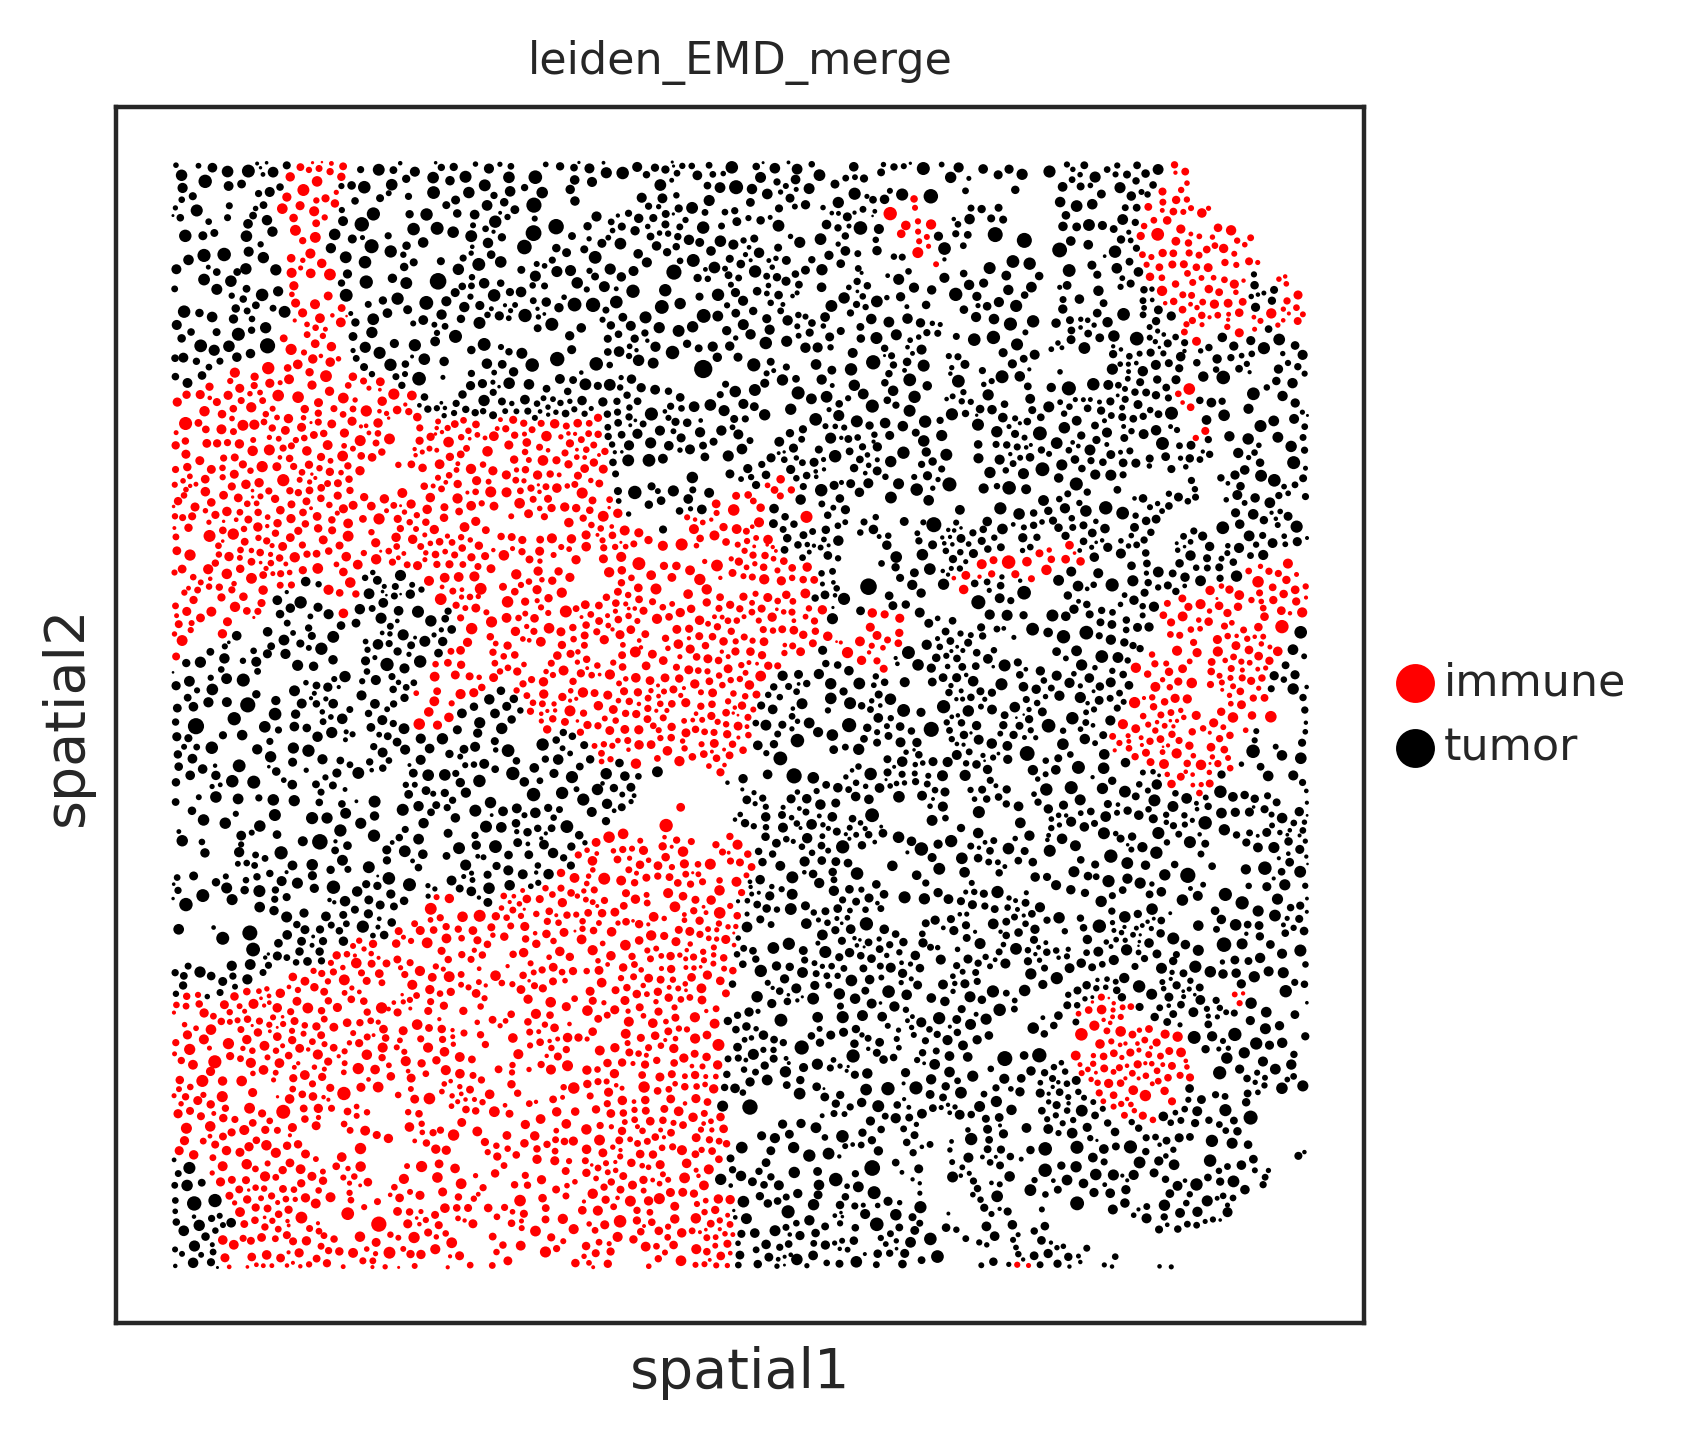

In [7]:
sc.pl.embedding(adata,basis='spatial',color=['leiden_EMD_merge'],size=adata.obs['cellSize']/50)

In [8]:
# 分别计算所有细胞到这两类区域的最短距离
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [9]:
for region in adata.obs['leiden_EMD_merge'].cat.categories:
    cur_idx = np.where(adata.obs['leiden_EMD_merge']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

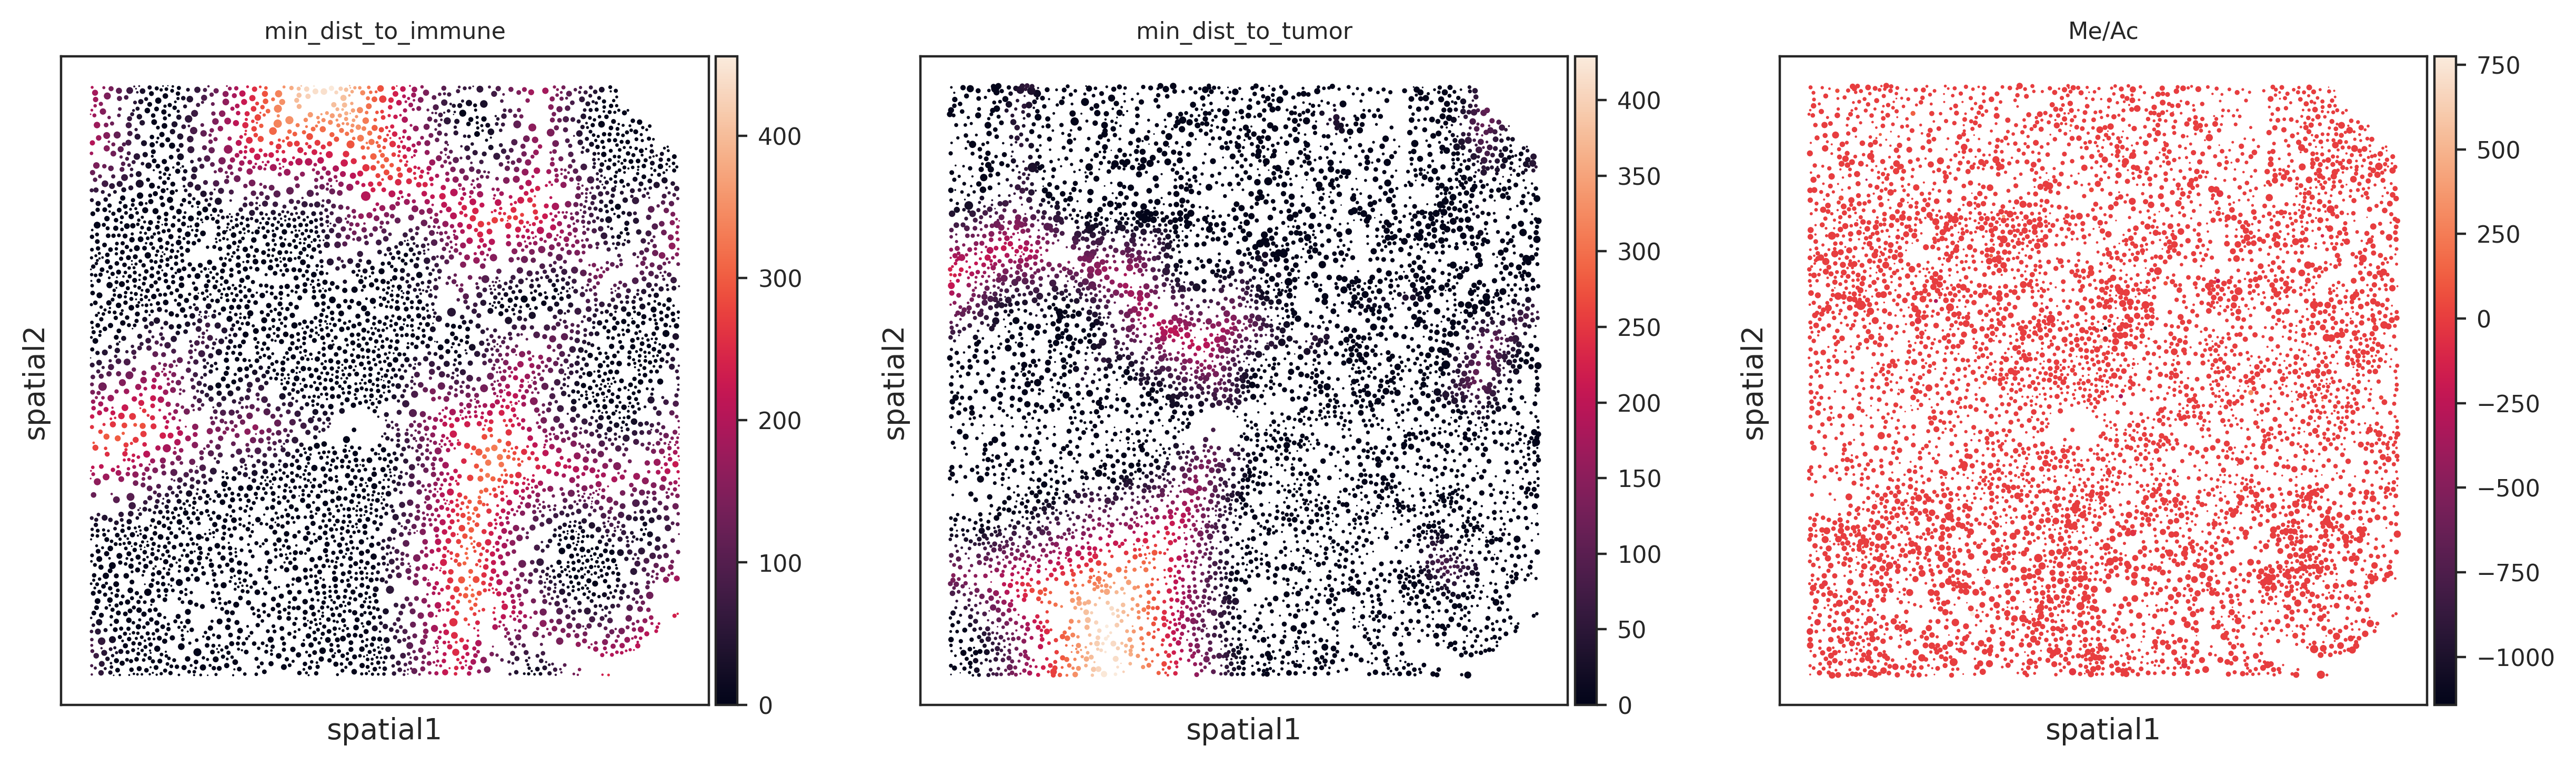

In [10]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor','Me/Ac'],size=adata.obs['cellSize']/50)

# polarize in tumor

In [11]:

# from original paper
boundary_sz_pixel = 100

In [12]:
boundary_array = np.array(adata.obs['leiden_EMD_merge'].copy())
min_dist_to_immune_array = np.array(adata.obs['min_dist_to_immune'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [13]:
boundary_array[(boundary_array=='tumor') & (min_dist_to_immune_array<=boundary_sz_pixel)] = 'boundary_tumor'
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary_immune'

In [14]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


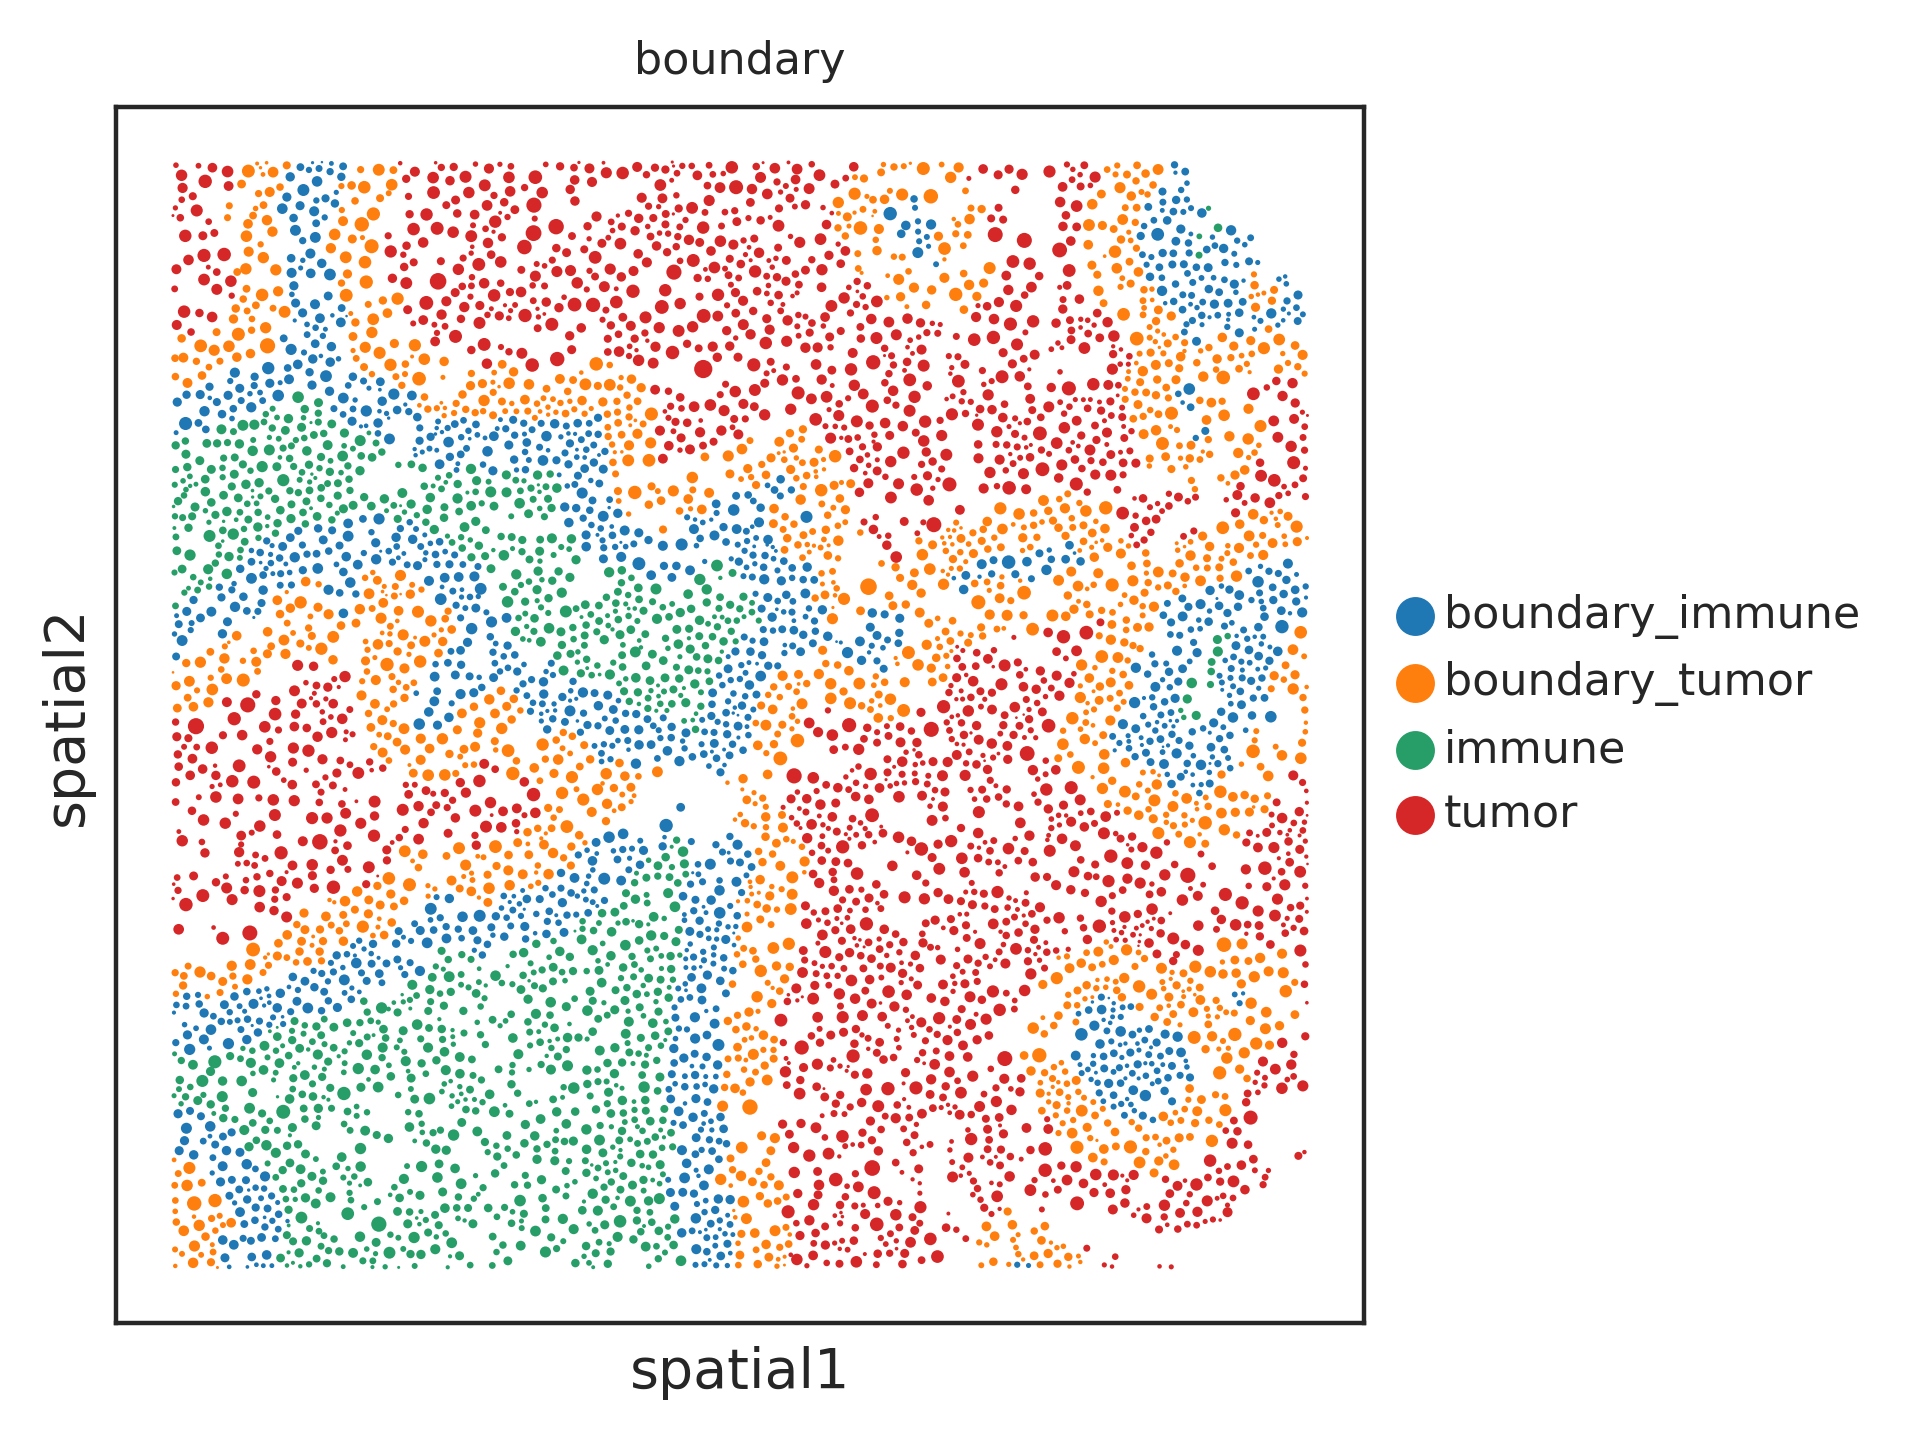

In [15]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cellSize']/50)

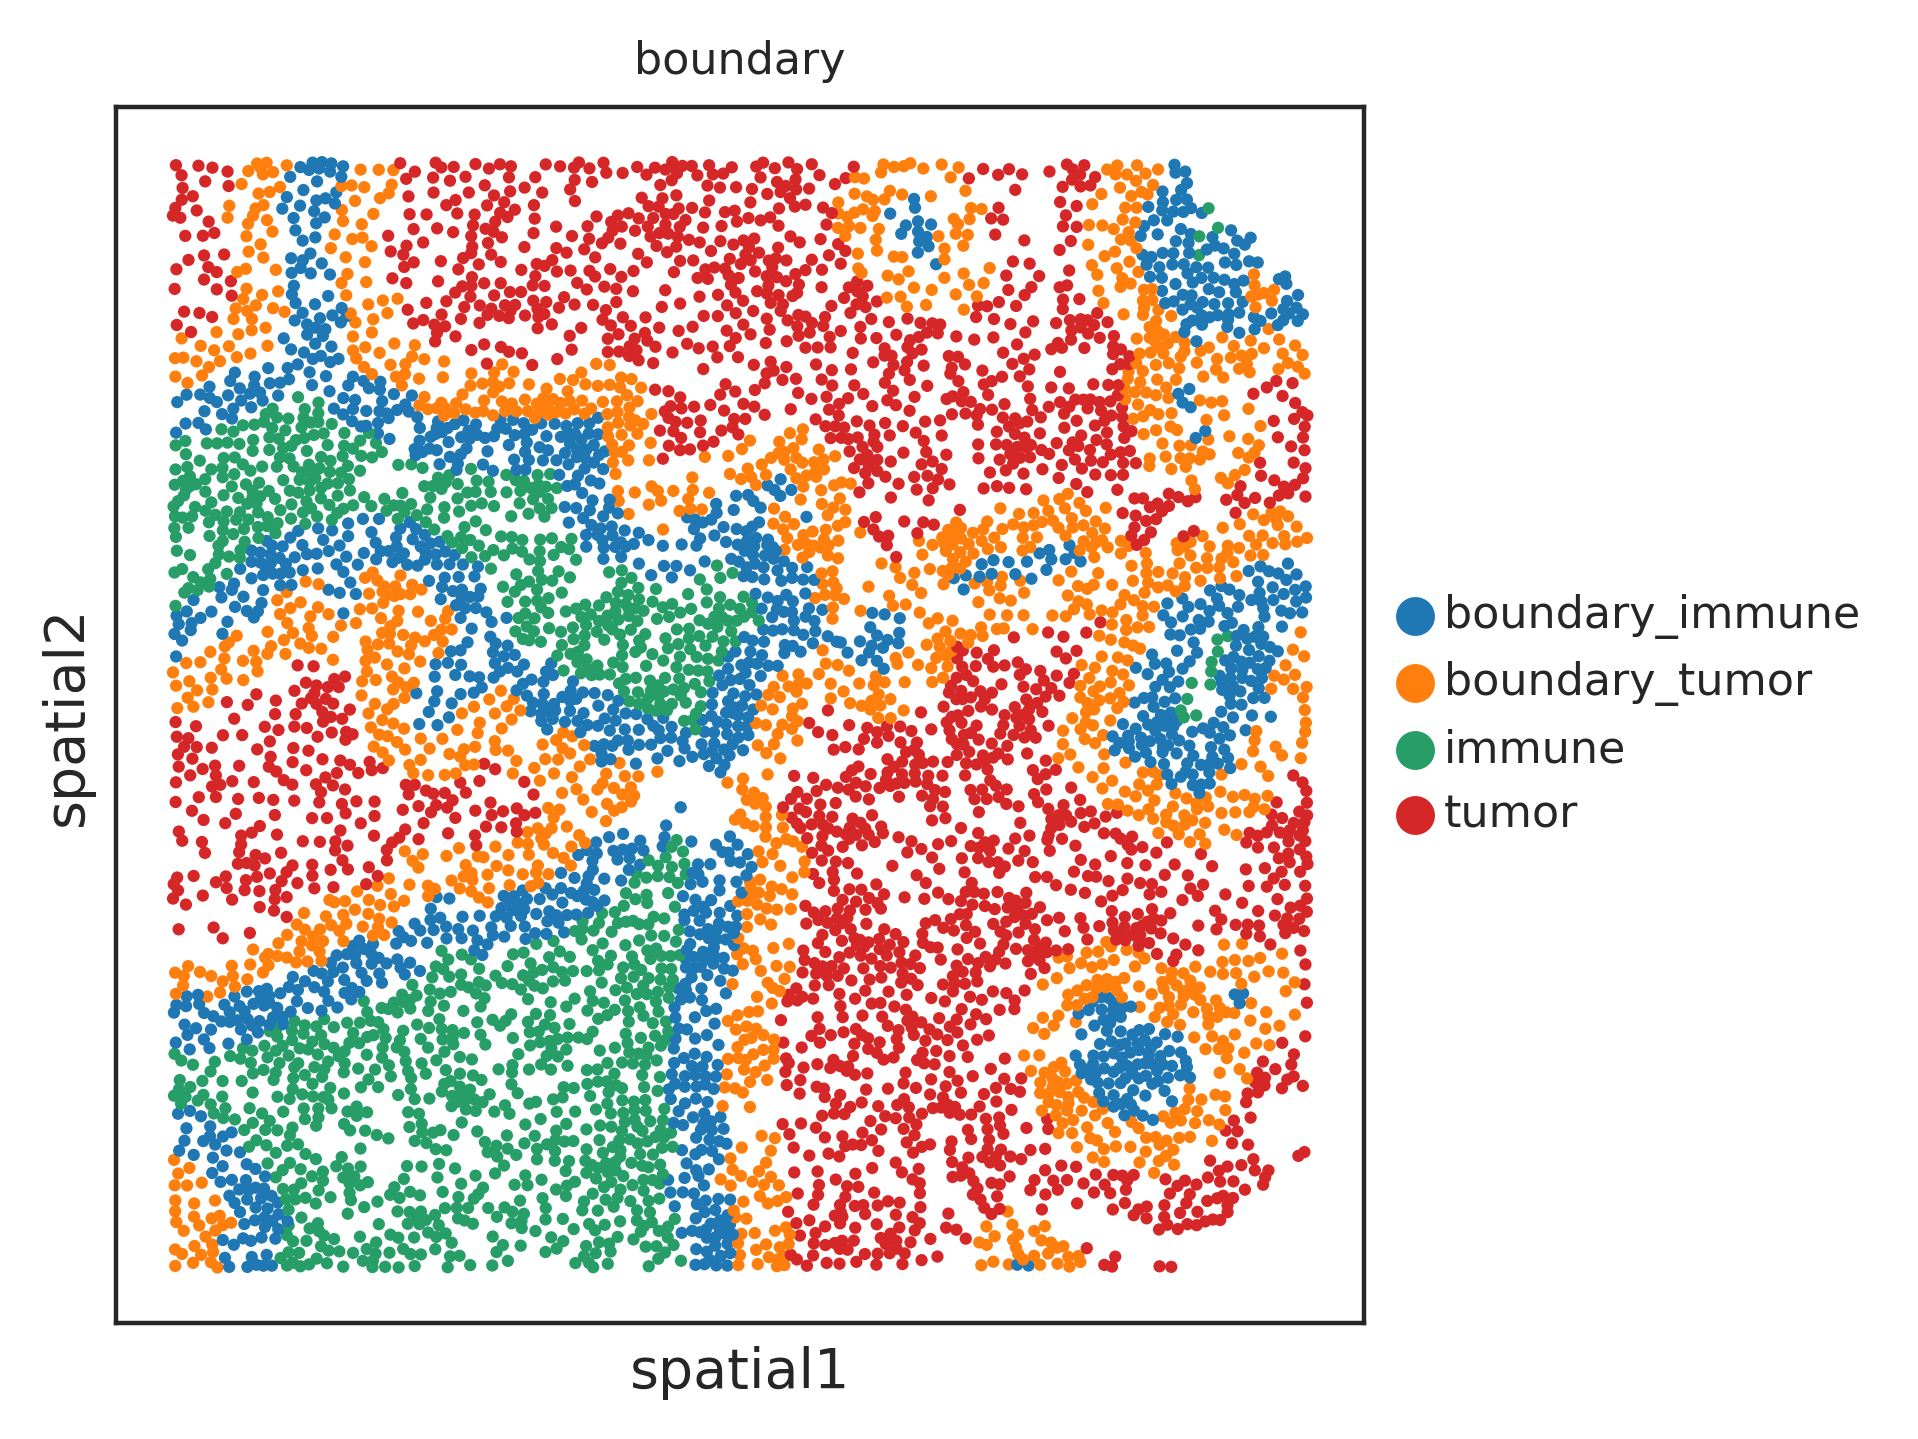

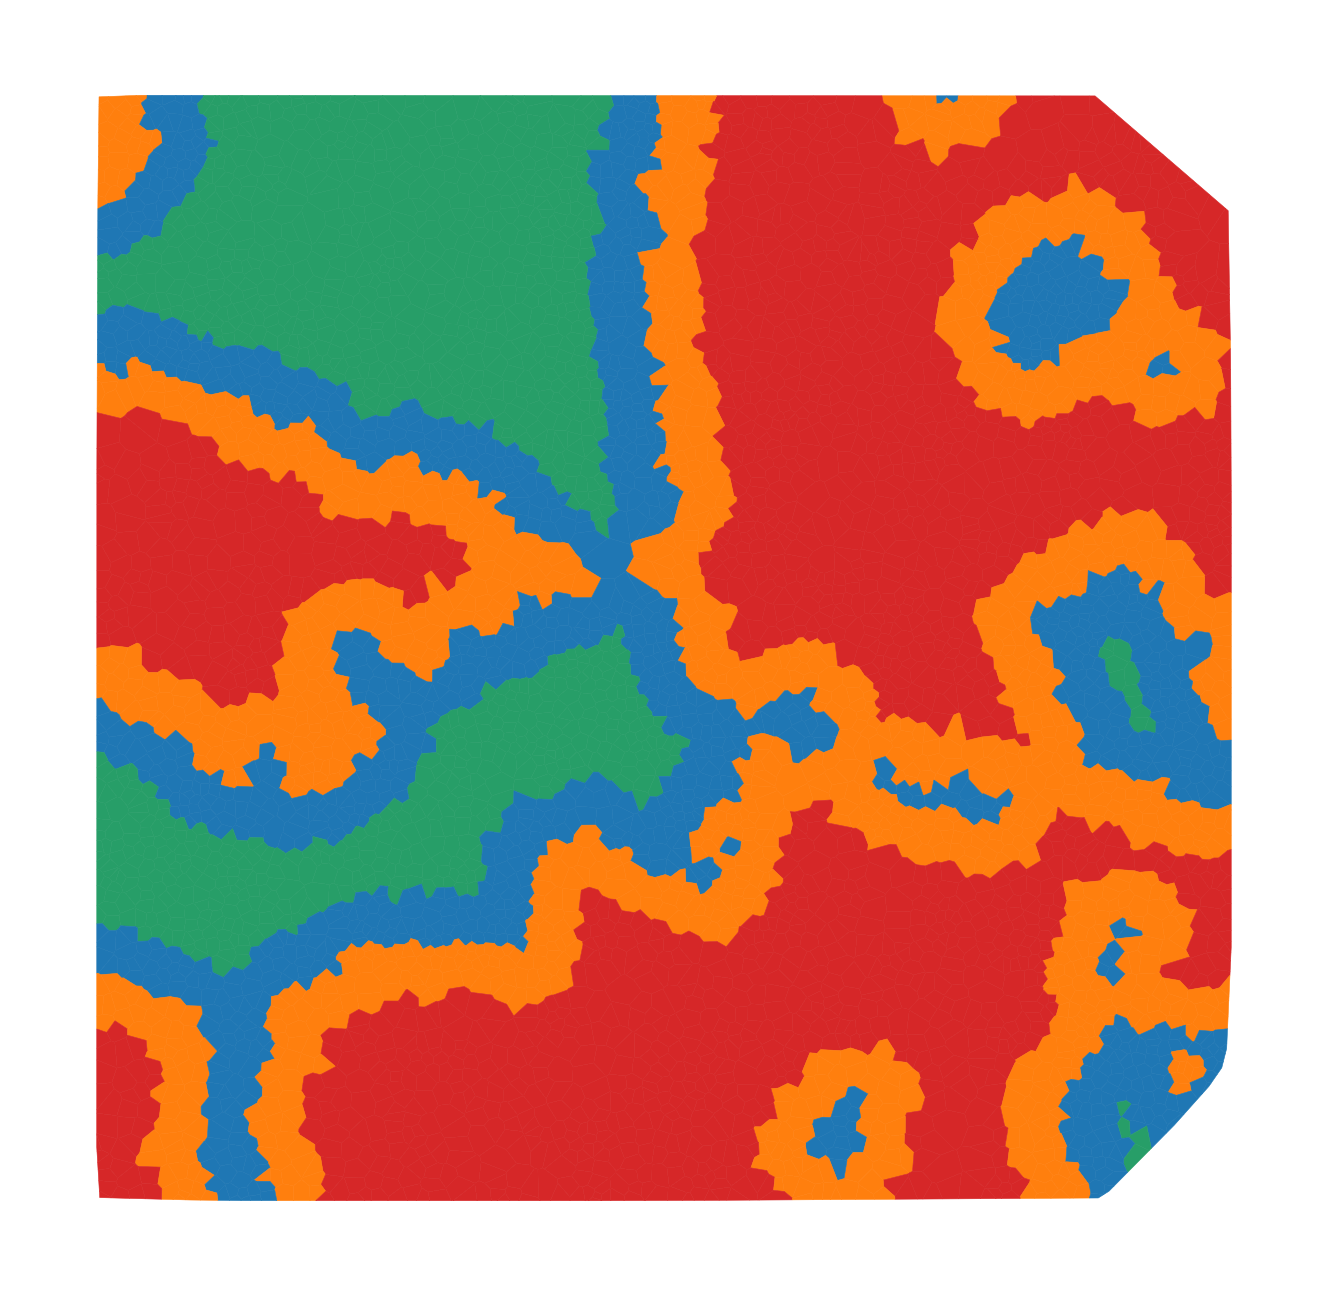

In [16]:
plot_voronoi_by_adata(adata,'boundary','spatial')

In [16]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='two-sided')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    
    
    
    return pv

# porlar to tumor, ranksum

In [47]:
ad_new

AnnData object with n_obs × n_vars = 6643 × 37
    obs: 'SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P', 'Ca', 'Fe', 'Background', 'B7H3', 'OX40', 'CD163', 'CSF-1R', 'Ta', 'Au', 'tumorYN', 'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup', 'group_name', 'immuneGroup_name', 'all_group_name', 'ME_heter_all_group_name_uniform', 'ME_heter_all_group_name_paga_guided_umap', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_immune', 'min_dist_to_tumor', 'boundary'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'spatial'
    obsp: 'ME_EMD_mat', 'connectivities', 'distances'

In [17]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_tumor','tumor']
var_name = 'sotip_polar_in_tumor'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [18]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_immune','immune']
var_name = 'sotip_polar_in_immune'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [19]:
adata.var

sotip_polar_in_tumor  sotip_polar_in_tumor_bh  \
dsDNA                 2.555902e-02             3.502533e-02   
Vimentin              5.259024e-43             3.243065e-42   
SMA                   2.393323e-02             3.405883e-02   
FoxP3                 7.481427e-01             7.908937e-01   
Lag3                  1.369119e-01             1.634109e-01   
CD4                   8.666979e-27             2.915256e-26   
CD16                  9.817176e-52             1.210785e-50   
CD56                  6.709234e-01             7.301225e-01   
PD1                   1.393955e-03             2.242449e-03   
CD31                  7.758216e-02             9.898414e-02   
PD-L1                 1.271993e-17             3.137584e-17   
EGFR                  4.142522e-01             4.789791e-01   
Ki67                  9.456954e-01             9.719647e-01   
CD209                 1.493119e-11             3.249730e-11   
CD11c                 2.045974e-43             1.892526e-42   
CD138                 4.348425e-16             1.005573e-15   
CD68                  1.308979e-29             5.381360e-29   
CD8                   1.644519e-19             4.346229e-19   
CD3                   7.023641e-41             3.712496e-40   
IDO                   1.822515e-08             3.549107e-08   
Keratin17             5.079477e-01             5.695171e-01   
CD63                  1.598374e-02             2.365594e-02   
CD45RO                7.638081e-66             1.413045e-64   
CD20                  1.306611e-06             2.197482e-06   
p53                   9.915234e-01             9.915234e-01   
Beta catenin          6.213819e-11             1.277285e-10   
HLA-DR                2.092267e-08             3.870695e-08   
CD11b                 1.909373e-20             5.434369e-20   
CD45                  1.592185e-70             5.891084e-69   
H3K9ac                7.252760e-29             2.683521e-28   
Pan-Keratin           3.977464e-23             1.226385e-22   
H3K27me3              6.653406e-03             1.025733e-02   
phospho-S6            3.130695e-43             2.316714e-42   
MPO                   1.265208e-01             1.560424e-01   
Keratin6              5.833033e-02             7.707937e-02   
HLA_Class_1           9.051143e-38             4.186154e-37   
Me/Ac                 3.060407e-07             5.392146e-07   

              sotip_polar_in_immune  sotip_polar_in_immune_bh  
dsDNA                  2.679322e-01              3.304497e-01  
Vimentin               9.565476e-51              1.179742e-49  
SMA                    1.258977e-03              1.940922e-03  
FoxP3                  9.107055e-01              9.395616e-01  
Lag3                   5.070093e-02              6.699766e-02  
CD4                    1.153363e-19              4.741604e-19  
CD16                   1.627145e-14              5.473123e-14  
CD56                   6.741741e-01              7.558922e-01  
PD1                    2.361505e-05              4.368784e-05  
CD31                   7.837145e-02              9.999116e-02  
PD-L1                  3.018686e-13              9.245892e-13  
EGFR                   9.685091e-01              9.685091e-01  
Ki67                   4.395252e-01              5.082010e-01  
CD209                  3.856704e-01              4.603163e-01  
CD11c                  5.153924e-38              3.178253e-37  
CD138                  3.875928e-53              7.170466e-52  
CD68                   1.550838e-04              2.608227e-04  
CD8                    4.370080e-25              2.021162e-24  
CD3                    6.489977e-29              3.430416e-28  
IDO                    3.166428e-07              6.508769e-07  
Keratin17              7.994817e-01              8.700242e-01  
CD63                   1.306850e-09              3.022091e-09  
CD45RO                 3.923118e-45              3.628884e-44  
CD20                   1.205729e-06              2.347998e-06  
p53                

In [24]:
gt_polarized_tumor_all = ['EGFR','Beta catenin','Pan-Keratin','p53','Ki67','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_all = ['CD20','CD209','CD11b','HLA-DR','FoxP3','Ki67','CD56','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']



In [20]:
gt_polarized_tumor_p4 = ['EGFR','Beta catenin','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_p4 = ['CD20','CD209','HLA-DR','FoxP3','PD-L1','IDO','CD45RO','CD4','CD11c','CD68']
gt_polarized_tumor_p9 = ['Me/Ac','PD-L1','HLA-DR']
gt_polarized_immune_p9 = ['CD20','CD11b','HLA-DR','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']

In [21]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_tumor'] = gt_polarized_array
adata.var['gt_polarized_tumor'][adata.var_names.isin(gt_polarized_tumor_p9)] = 1

In [22]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_immune'] = gt_polarized_array
adata.var['gt_polarized_immune'][adata.var_names.isin(gt_polarized_immune_p9)] = 1

In [23]:
adata.write_h5ad('sotip_polar_test_p9.h5ad')